In [1]:
# Datenzugriff
from configs.config import get_path

# Utils
import src.utils.presenter as show
from src.utils.production_process import initialize as init
from src.utils.analize import check_constrains as check

from src.utils.production_process import gen_deadline as gen_deadline

# Solver Model
import src.models.heuristics.fcfs as fcfs

# Extern
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 21)

In [2]:
basic_data_path = get_path("data", "basic")
day_count = 1

df_instance = pd.read_csv(basic_data_path / "instance.csv")
df_jssp, df_job_arrivals = init.create_production_orders_for_shifts(df_template=df_instance, shift_count=day_count,
                                                                 u_b_mmax= 0.94, shift_length=1440, shuffle=True,
                                                                 job_seed=40, arrival_seed=80)

df_jobs_times = gen_deadline.get_times_df(df_jssp, df_job_arrivals, fcfs.schedule_with_arrivals, target_service=1.0)
df_jobs_times['Ready Time'] = ((df_jobs_times['Arrival'] // 1440) + 1) * 1440

df_jobs_times["Deadline"] = df_jobs_times["Deadline"] + 900
df_jobs_times


Schedule-Informationen:
  Makespan: 2400


,Job,Production_Plan_ID,Arrival,Deadline,Ready Time
0,0,0,49,1748.0,1440
1,1,1,130,2062.0,1440
2,2,2,151,2200.0,1440
3,3,3,226,2451.0,1440
4,4,4,386,2081.0,1440
5,5,5,464,2367.0,1440
6,6,6,480,2222.0,1440
7,7,7,506,2496.0,1440
8,8,8,526,2634.0,1440
9,9,9,535,2527.0,1440


In [3]:
#df_jobs_times = gen_deadline.assign_deadlines_with_global_lognormal_mode(df_jobs_times, sigma=0.5, 
#                                                                         basic_slack=60, seed=50, global_modus=2880)

#df_jobs_times

In [4]:
import pandas as pd
import random
from collections import defaultdict

def giffler_thompson_schedule(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    priority_rule: str = "SPT",
    log_on: bool = True
) -> pd.DataFrame:
    """
    Giffler-Thompson-Algorithmus mit Ready Time (für Planung) und Arrival (für Ausgabe).
    Rückgabe mit Lateness, Tardiness, Earliness.

    Rückgabe:
    - df_schedule: DataFrame mit Zeitplan und Auswertung
    - makespan: maximale Endzeit
    - total_abs_lateness: Summe der absoluten Lateness der letzten Operationen je Job
    """

    if log_on: 
        print(f'Giffler-Thompson-Algorithmus mit Prioritätsregel \"{priority_rule}\" gestartet ...\n')

    df = df_jssp.copy().sort_values(['Job', 'Operation']).reset_index(drop=True)
    machines = set(df['Machine'])
    jobs = df['Job'].unique()

    ready_time = df_arrivals_deadlines.set_index("Job")["Ready Time"].to_dict()
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()

    job_op_ready = {job: 0 for job in jobs}
    machine_available = {m: 0 for m in machines}
    job_op_index = {job: 0 for job in jobs}

    job_ops = defaultdict(list)
    for _, row in df.iterrows():
        job_ops[row['Job']].append((row['Operation'], row['Machine'], row['Processing Time']))

    result = []
    remaining = sum(len(v) for v in job_ops.values())

    while remaining > 0:
        candidates = []
        for job in jobs:
            idx = job_op_index[job]
            if idx < len(job_ops[job]):
                op_id, m, d = job_ops[job][idx]
                est = max(job_op_ready[job], machine_available[m], ready_time[job])
                candidates.append((est, d, job, op_id, m))

        min_est = min(c[0] for c in candidates)
        conflict_ops = [c for c in candidates if c[0] == min_est]

        if priority_rule == "SPT":
            selected = min(conflict_ops, key=lambda x: x[1])
        elif priority_rule == "EDF" or priority_rule == "EDD":
            selected = min(conflict_ops, key=lambda x: deadline[x[2]])  # x[2] ist der Job
        else:  # RANDOM oder unbekannt
            selected = random.choice(conflict_ops)

        est, d, job, op_id, m = selected
        start = est
        end = start + d

        result.append({
            'Job': job,
            'Operation': op_id,
            'Machine': m,
            'Start': start,
            'Processing Time': d,
            'End': end
        })

        job_op_ready[job] = end
        machine_available[m] = end
        job_op_index[job] += 1
        remaining -= 1

    # Berechnung von Lateness, Tardiness, Earliness
    for row in result:
        job = row['Job']
        lateness_val = row['End'] - deadline[job]
        row.update({
            "Arrival": arrival[job],
            "Deadline": deadline[job],
            "Lateness": lateness_val,
            "Tardiness": max(0, lateness_val),
            "Earliness": max(0, -lateness_val)
        })

    df_schedule = pd.DataFrame(result).sort_values(['Start', 'Job', 'Operation']).reset_index(drop=True)

    last_ops = df_schedule.groupby("Job")["Operation"].max()
    last_op_index_tuples = list(zip(last_ops.index, last_ops.values))
    mask_last_ops = df_schedule.set_index(["Job", "Operation"]).index.isin(last_op_index_tuples)
    total_abs_lateness = df_schedule[mask_last_ops]["Lateness"].abs().sum()

    ende = df_schedule['End'].max()

    if log_on:
        print("\nPlan-Informationen:")
        print(f"  Anzahl Jobs            : {len(jobs)}")
        print(f"  Anzahl Maschinen       : {len(machines)}")
        print(f"  Anzahl Operationen     : {len(df_schedule)}")
        print(f"  Ende                   : {ende}")
        print(f"  Summe Absolute Lateness: {total_abs_lateness}")

    return df_schedule


### SPT

In [5]:
df_schedule = giffler_thompson_schedule(
    df_jssp=df_jssp,
    df_arrivals_deadlines=df_jobs_times,
    priority_rule="SPT",
    log_on=True
)

last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Tardiness", max_val = 840, steps= 120)

Giffler-Thompson-Algorithmus mit Prioritätsregel "SPT" gestartet ...


Plan-Informationen:
  Anzahl Jobs            : 20
  Anzahl Maschinen       : 10
  Anzahl Operationen     : 200
  Ende                   : 3175
  Summe Absolute Lateness: 7942.0


label
0            12
0 - 120       1
120 - 240     2
240 - 360     1
360 - 480     2
480 - 600     1
600 - 720     0
720 - 840     0
>840          1
Name: count, dtype: int64

### EDD (EDF)

In [6]:
df_schedule = giffler_thompson_schedule(
    df_jssp=df_jssp,
    df_arrivals_deadlines=df_jobs_times,
    priority_rule="EDF",
    log_on=True
)

df_schedule

Giffler-Thompson-Algorithmus mit Prioritätsregel "EDF" gestartet ...


Plan-Informationen:
  Anzahl Jobs            : 20
  Anzahl Maschinen       : 10
  Anzahl Operationen     : 200
  Ende                   : 3263
  Summe Absolute Lateness: 1492.0


,Job,Operation,Machine,Start,Processing Time,End,Arrival,Deadline,Lateness,Tardiness,Earliness
0,0,0,M00,1440,29,1469,49,1748.0,-279.0,0.0,279.0
1,2,0,M01,1440,91,1531,151,2200.0,-669.0,0.0,669.0
2,4,0,M02,1440,14,1454,386,2081.0,-627.0,0.0,627.0
3,5,0,M02,1454,84,1538,464,2367.0,-829.0,0.0,829.0
4,1,0,M00,1469,43,1512,130,2062.0,-550.0,0.0,550.0
...,...,...,...,...,...,...,...,...,...,...,...
195,16,9,M08,3155,30,3185,1254,3186.0,-1.0,0.0,1.0
196,19,8,M07,3178,30,3208,1398,3140.0,68.0,68.0,0.0
197,17,8,M09,3179,22,3201,1285,3510.0,-309.0,0.0,309.0
198,17,9,M05,3201,43,3244,1285,3510.0,-266.0,0.0,266.0


In [7]:
last_ops = df_schedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Tardiness", max_val = 840, steps= 120)

label
0            11
0 - 120       6
120 - 240     3
240 - 360     0
360 - 480     0
480 - 600     0
600 - 720     0
720 - 840     0
>840          0
Name: count, dtype: int64

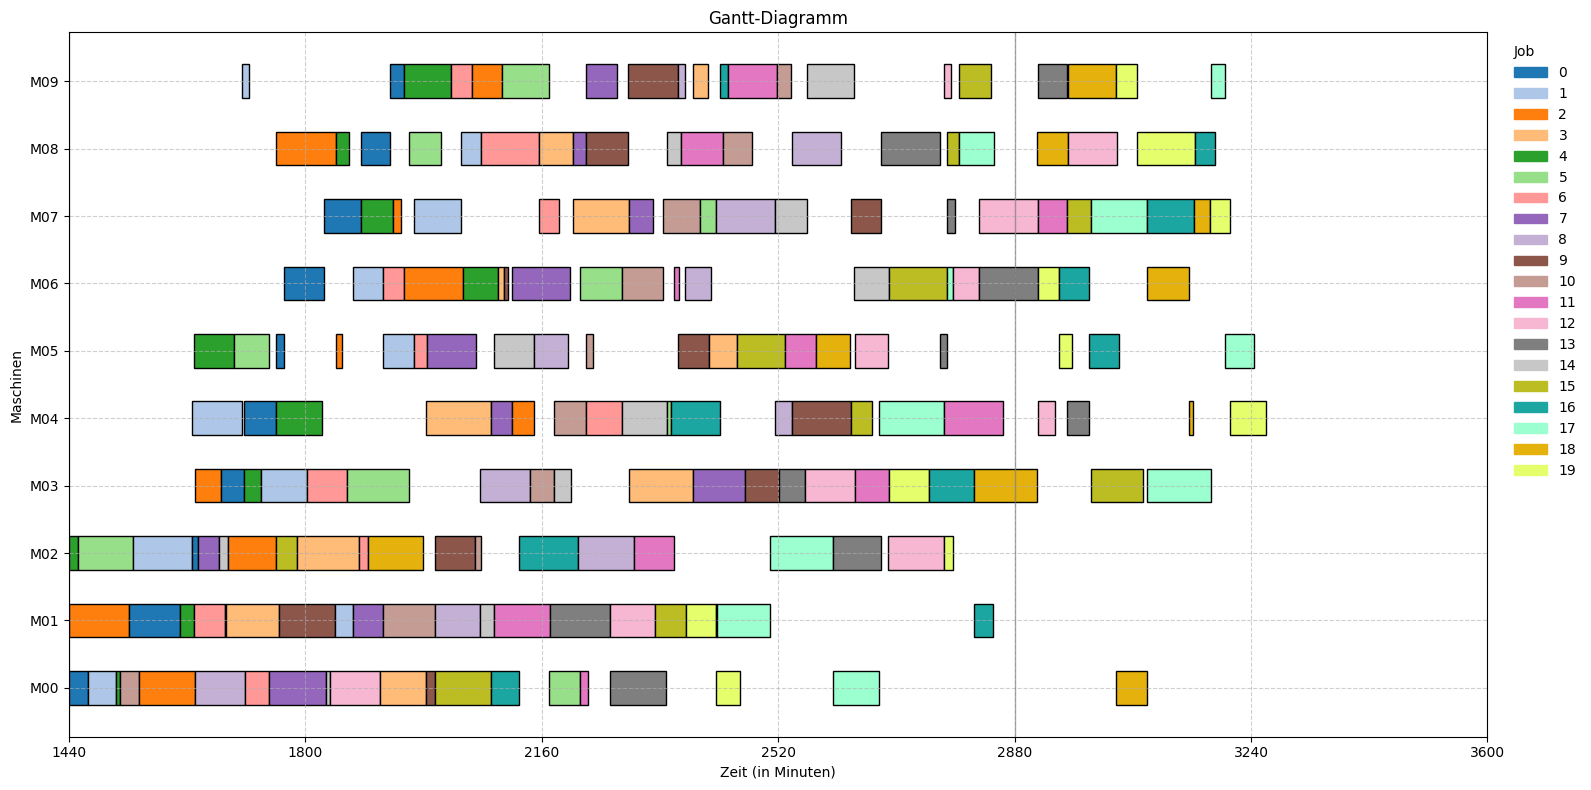

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [8]:
show.plot_gantt(df_schedule, perspective="Machine")

check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)
check.is_start_correct(df_schedule)